In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_score , RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import mlflow
from mlflow.tracking import MlflowClient

import pickle

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_pickle("../data/interim/04_data_features.pkl")

In [3]:
# Remove non-feature columns from the DataFrame to create the training set
# "participant", "category", "set", and "duration" 
# are dropped as they are not considered features
df_train = df.drop(["participant","category","set","duration"],axis = 1)

# Separate features (X) and labels (y) from the training set
X = df_train.drop("label",axis = 1) # Features
y = df_train["label"] # Target

# Split the data into training and test sets using stratified sampling to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

# Define different subsets of features based on their characteristics
# These subsets depend on the feature engineering performed earlier
basic_features = ["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]
sqaured_features = ["acc_r","gyr_r"]
pca_features = ["pca_1","pca_2","pca_3"]
time_features = [f for f in df_train.columns if "_temp" in f]
freq_features = [f for f in df_train.columns if ("_freq" in f) or ("_pse" in f)]
cluster_features = ["cluster_label"]


# Define different combinations of feature subsets
# These combinations are based on the feature engineering results
feature_1 = list(set(basic_features))  # Features from basic sensor readings only
feature_2 = list(set(basic_features + sqaured_features + pca_features))  # Additional derived and transformed features
feature_3 = list(set(feature_2 + time_features))  # Includes time-domain features
feature_4 = list(set(feature_3 + freq_features + cluster_features))  # Includes frequency-domain and cluster-based features

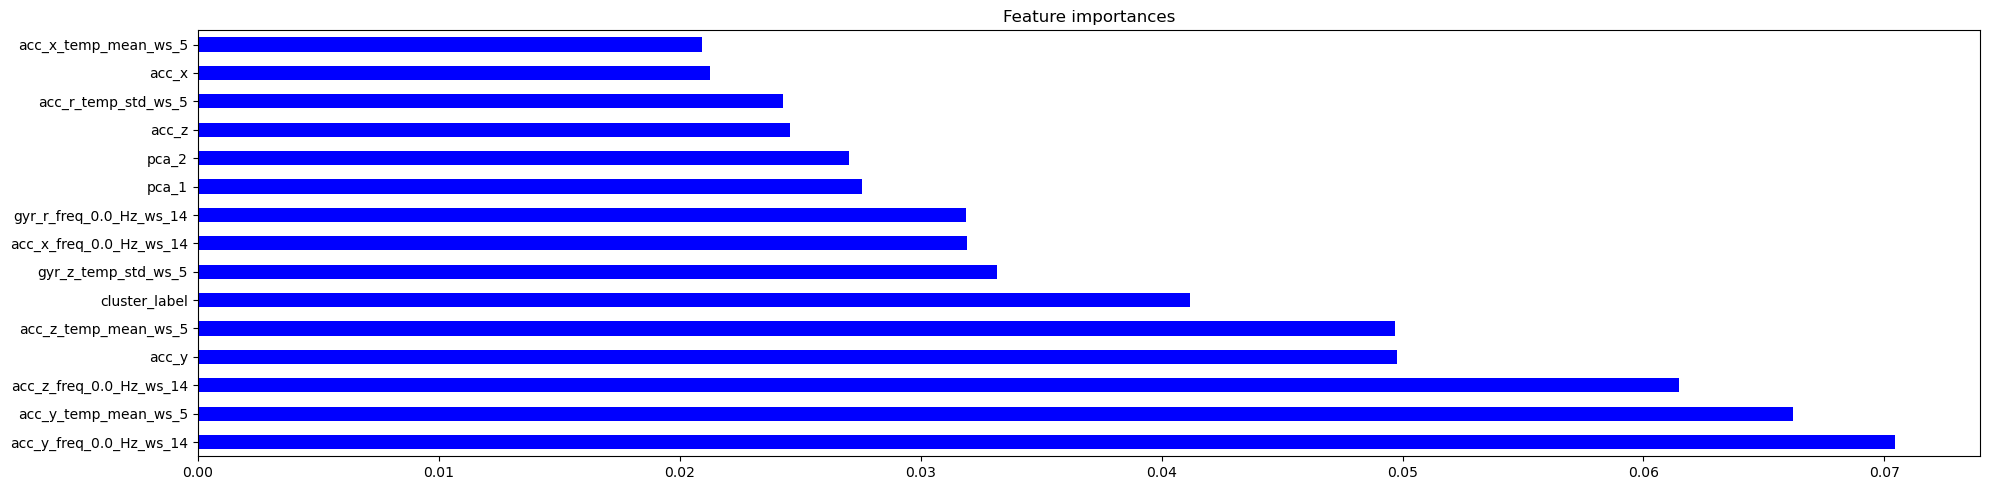

In [4]:
ex=ExtraTreesClassifier()
ex.fit(X,y)
ExtraTreesClassifier()
ex.feature_importances_
feat=pd.Series(ex.feature_importances_,index=X.columns)

plt.figure(figsize=(20,5))
plt.title('Feature importances')
feat=pd.Series(ex.feature_importances_,index=X.columns)
feat.nlargest(15).plot(kind='barh', color="b", align="center")
plt.tight_layout()
plt.grid(False)
plt.show()

In [5]:
selected_features = feat.nlargest(15).index
selected_features = list(selected_features)
selected_features

['acc_y_freq_0.0_Hz_ws_14',
 'acc_y_temp_mean_ws_5',
 'acc_z_freq_0.0_Hz_ws_14',
 'acc_y',
 'acc_z_temp_mean_ws_5',
 'cluster_label',
 'gyr_z_temp_std_ws_5',
 'acc_x_freq_0.0_Hz_ws_14',
 'gyr_r_freq_0.0_Hz_ws_14',
 'pca_1',
 'pca_2',
 'acc_z',
 'acc_r_temp_std_ws_5',
 'acc_x',
 'acc_x_temp_mean_ws_5']

# Modeling

---


### initialization mlflow


In [6]:
EXPERIMENT_NAME = "Baseline Model"
EXPERIMENT_MODEL_PATH = "Baseline_Model.pkl"

### 0)Baseline model


In [7]:
## Create a baseline model "Logistic Regression" using only the basic features 
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train[basic_features],y_train)

LogisticRegression()

In [8]:
logistic_reg_pred = logistic_reg.predict(X_test[basic_features])

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7466390899689762


In [10]:
with open ("../models/01_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(logistic_reg, f)

Tracking with mlflow

In [11]:
# Initialize the MLflow client
client = MlflowClient()


In [12]:
# Initialization
mlflow.set_experiment(EXPERIMENT_NAME)
exp = client.get_experiment_by_name(EXPERIMENT_NAME)

2024/03/23 07:29:29 INFO mlflow.tracking.fluent: Experiment with name 'Baseline Model' does not exist. Creating a new experiment.


In [13]:
with mlflow.start_run(experiment_id=exp.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "basic")
    mlflow.log_metric("accuracy", accuracy)
    
    ## Log the model
    mlflow.log_artifact("../models/01_"+EXPERIMENT_MODEL_PATH)

In [14]:
mlflow.search_runs(experiment_ids=exp.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user
0,b6d2ac790662459f9fccce0735224787,737819963720326942,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 05:29:31.722000+00:00,2024-03-23 05:29:31.969000+00:00,0.746639,basic,angry-doe-922,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...,LOCAL,HP


### 1)choose model


In [15]:
# Define dictionary of models
models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Gradient Boosting Classifier': GradientBoostingClassifier(),
          'Support Vector Machine': SVC(),
          'Stochastic Gradient Descent': SGDClassifier(),
          'Naive Bayes': GaussianNB()}

### 2)Train the model


In [16]:
def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                             scoring='accuracy',
                                             cv=3
                                             ).mean()

    return model_scores


### 3)Evaluate the model


In [17]:

# Definedictionary of features_set
feature_sets = {'feature_1': feature_1,
                'feature_2': feature_2,
                'feature_3': feature_3,
                'feature_4': feature_4,
                'selected_features': selected_features}
i= 0

for feature_set_name, features in feature_sets.items():
    X_train_features = X_train[features]
    X_test_features = X_test[features]
    
    model_scores = fit_score(models, X_train_features, X_test_features, y_train, y_test)
    print(f"Results for {feature_set_name}:")
    for model, score in model_scores.items():
        """
        EXPERIMENT_NAME = model
        EXPERIMENT_MODEL_PATH = model +".pkl"
        
        # Initialization
        mlflow.set_experiment(EXPERIMENT_NAME)
        exp = client.get_experiment_by_name(EXPERIMENT_NAME)
        
        i+=1
        with open ("../models/"+str(i)+"_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
            pickle.dump(model, f)
            
        with mlflow.start_run(experiment_id=exp.experiment_id):
            ## Log the parameters and metrics
            mlflow.log_param("features", feature_set_name)
            mlflow.log_metric("accuracy", score)
            
            ## Log the model
            mlflow.log_artifact("../models/"+str(i)+"_"+EXPERIMENT_MODEL_PATH)
    
    """
        print(f"{model}: {score}")
    print("\n")

Results for feature_1:
Logistic Regression: 0.7073566268612709
Decision Tree: 0.8572838746482575
Random Forest: 0.9193508066842297
Gradient Boosting Classifier: 0.8965957092219039
Support Vector Machine: 0.556390977443609
Stochastic Gradient Descent: 0.5098904550378504
Naive Bayes: 0.8355896134197387


Results for feature_2:
Logistic Regression: 0.7466908960380492
Decision Tree: 0.8417879737707441
Random Forest: 0.9048933074373914
Gradient Boosting Classifier: 0.8986693075399496
Support Vector Machine: 0.5491317808587967
Stochastic Gradient Descent: 0.5088135940875206
Naive Bayes: 0.8531751373318205


Results for feature_3:
Logistic Regression: 0.8883077258363299
Decision Tree: 0.9007525206879091
Random Forest: 0.9586530264279625
Gradient Boosting Classifier: 0.9493554859014545
Support Vector Machine: 0.752863616842618
Stochastic Gradient Descent: 0.7197950118262407
Naive Bayes: 0.9369619701427482


Results for feature_4:
Logistic Regression: 0.8665910300046793
Decision Tree: 0.9513810

### 4)hyperparameter tuning


#RF of features set 4

In [18]:
param_grid = {
    'n_estimators': [50, 200, 400],
    'max_depth': [3, 10,None],
    'max_features': ['auto', 'sqrt', 'log2']
}


RF_4f = RandomizedSearchCV(estimator=RandomForestClassifier(),
                           param_distributions=param_grid,
                           n_iter=100,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           random_state=42,
                           n_jobs=-1)

RF_4f.fit(X_train[feature_4], y_train)

RF_4f.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None}

In [20]:
RF_4f.best_score_

0.9937952430196484

In [26]:
model_RF_4f = RandomForestClassifier(n_estimators= 200, max_features= 'sqrt', max_depth= None)
model_RF_4f.fit(X_train[feature_4], y_train)
y_pred_4f = model_RF_4f.predict(X_test[feature_4])


In [27]:
accuracy_F4 = accuracy_score(y_test, y_pred_4f)
accuracy_F4

0.9958634953464323

In [28]:

EXPERIMENT_NAME = "RF_F4_Model"
EXPERIMENT_MODEL_PATH = "RF_F4_Model.pkl"

with open ("../models/02_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(model_RF_4f, f)

# Initialization

mlflow.set_experiment(EXPERIMENT_NAME)
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=exp.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "feature_4")
    mlflow.log_metric("accuracy", accuracy_F4)
    
    ## Log the model
    mlflow.log_artifact("../models/02_"+EXPERIMENT_MODEL_PATH)

2024/03/23 07:46:14 INFO mlflow.tracking.fluent: Experiment with name 'RF_F4_Model' does not exist. Creating a new experiment.


In [29]:
    
mlflow.search_runs(experiment_ids=exp.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user
0,85e5c42888b947c4964f1fad0e46dd94,319780399889110637,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 05:46:14.566000+00:00,2024-03-23 05:46:14.778000+00:00,0.995863,feature_4,adorable-sloth-99,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...,LOCAL,HP


#RF for selected_features

In [32]:
param_grid = {
    'n_estimators': [50, 200,400],
    'max_depth': [3, 10,None],
    'max_features': ['auto', 'sqrt', 'log2']
}


RF_sf = RandomizedSearchCV(estimator=RandomForestClassifier(),
                           param_distributions=param_grid,
                           n_iter=100,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           random_state=42,
                           n_jobs=-1)

RF_sf.fit(X_train[selected_features], y_train)

RF_sf.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'n_estimators': 200, 'max_features': 'log2', 'max_depth': 10}

In [33]:
RF_sf.best_score_

0.9896587383660806

In [34]:
model_RF_sf = RandomForestClassifier(n_estimators= 200, max_features= 'log2', max_depth= 10)
model_RF_sf.fit(X_train[selected_features], y_train)
y_pred_sf = RF_sf.predict(X_test[selected_features])


In [35]:
accuracy_sf = accuracy_score(y_test, y_pred_sf)
accuracy_sf

0.9906928645294726

In [36]:

EXPERIMENT_NAME = "RF_SF_Model"
EXPERIMENT_MODEL_PATH = "RF_SF_Model.pkl"

with open ("../models/03_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(model_RF_sf, f)

# Initialization

mlflow.set_experiment(EXPERIMENT_NAME)
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=exp.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "selected_features")
    mlflow.log_metric("accuracy", accuracy_sf)
    
    ## Log the model
    mlflow.log_artifact("../models/03_"+EXPERIMENT_MODEL_PATH)

2024/03/23 07:47:54 INFO mlflow.tracking.fluent: Experiment with name 'RF_SF_Model' does not exist. Creating a new experiment.


In [37]:
    
mlflow.search_runs(experiment_ids=exp.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user
0,900f914e01144c098e9f2cec94775001,162772175002405275,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 05:47:55.008000+00:00,2024-03-23 05:47:55.105000+00:00,0.990693,selected_features,capricious-fox-232,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...,LOCAL,HP


### 5) final evaluation


In [38]:
model = RandomForestClassifier(n_estimators= 200, max_features= 'sqrt', max_depth= None)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])


In [39]:
acc = accuracy_score(y_test, y_pred)
acc

0.9927611168562565

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       bench       0.99      0.99      0.99       175
        dead       0.99      0.98      0.99       172
         ohp       0.99      0.99      0.99       175
        rest       1.00      1.00      1.00       128
         row       0.98      0.99      0.99       142
       squat       1.00      1.00      1.00       175

    accuracy                           0.99       967
   macro avg       0.99      0.99      0.99       967
weighted avg       0.99      0.99      0.99       967



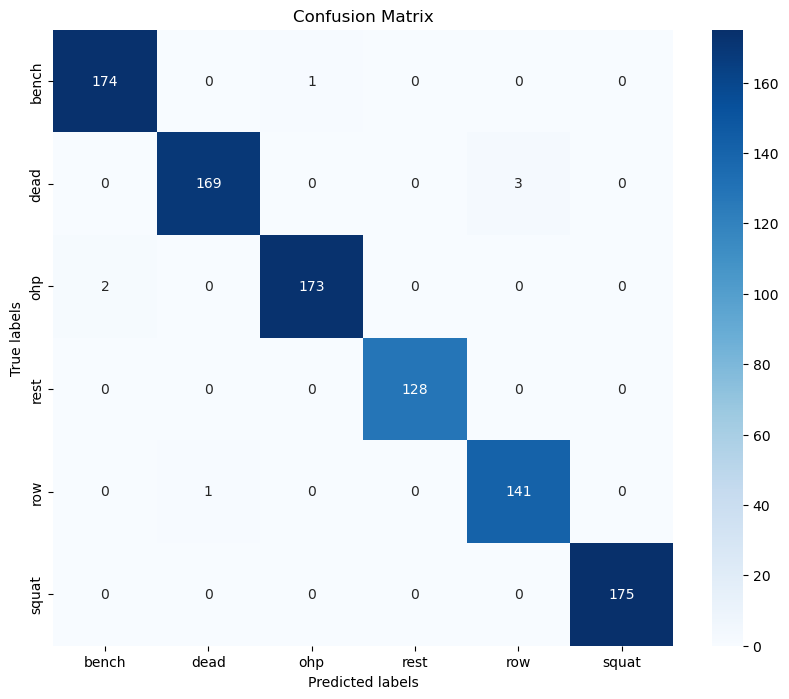

In [41]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



### 6)Interpretation of model parameters


In [212]:

# Get feature importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]


### 7) final model


In [42]:

EXPERIMENT_NAME = "Model"
EXPERIMENT_MODEL_PATH = "Model.pkl"

with open ("../models/04_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(model, f)

# Initialization

mlflow.set_experiment(EXPERIMENT_NAME)
exp = client.get_experiment_by_name(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=exp.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "selected_features")
    mlflow.log_metric("accuracy", acc)
    
    ## Log the model
    mlflow.log_artifact("../models/04_"+EXPERIMENT_MODEL_PATH)

2024/03/23 07:48:59 INFO mlflow.tracking.fluent: Experiment with name 'Model' does not exist. Creating a new experiment.


In [43]:
    
mlflow.search_runs(experiment_ids=exp.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user
0,f906017484cb466796c72bd160b7aee3,509956748826229669,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 05:48:59.488000+00:00,2024-03-23 05:48:59.606000+00:00,0.992761,selected_features,capable-snipe-422,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...,LOCAL,HP


# Model deployment

---
